In [1]:
import jax.numpy as np
from matplotlib import pyplot as plt
from jax import grad, vmap, jit, partial, random
import numpy as onp
from jax.experimental import optimizers
key = random.PRNGKey(0)
import pickle
from jax.config import config
config.update("jax_enable_x64", True)

from NODE_fns import NODE_lm2sigma_vmap, init_params, node_traj

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
model_name = 'P12AC1_sy'
dataset_name = 'P12AC1_sy'

with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lamb, sigma_gt = np.load(f,allow_pickle=True)
n_data = lamb.shape[0]
weights1 = onp.ones([n_data,1]) # Weight of the loss components. Useful sometimes.
weights2 = onp.ones([n_data,1])
if dataset_name == 'rubber20UT_ET_PS':
    weights2[42:] = 0 #Ignore the loss on sigma_yy in strip-biaxial data since we don't have it.
if dataset_name == 'rubber50UT_ET_PS':
    weights2[33:] = 0
sigma_gt = np.hstack((sigma_gt,weights1,weights2))

In [3]:
#Find normalization constants
lm1,lm2 = lamb.T
lm3 = 1/(lm1*lm2)

z = np.zeros_like(lm1)
F = np.array([[lm1, z, z],
              [z, lm2, z],
              [z, z, lm3]])
F = np.mean(F, axis=2)
C = np.einsum('ji,jk->ik', F, F)
Cinv = np.linalg.inv(C)
C2 = np.einsum('ij,jk->ik', C, C)
I1 = C[0,0] + C[1,1] + C[2,2]
I2 = 0.5*(I1**2 - np.trace(C2))

sigma = np.mean(sigma_gt, axis=0)
sigma = np.array([[sigma[0], 0, 0],
                  [0, sigma[1], 0],
                  [0, 0,        0]])
S = np.einsum('ij,jk,kl', np.linalg.inv(F), sigma, np.linalg.inv(F).T)

a = np.array([[2, 2*(I1-C[0,0]), Cinv[0,0]],
              [2, 2*(I1-C[1,1]), Cinv[1,1]],
              [2, 2*(I1-C[2,2]), Cinv[2,2]],])
b = np.array([S[0,0], S[1,1], S[2,2]])
[Psi1, Psi2, p] = np.linalg.lstsq(a,b)[0]
norm = [I1-3, I2-3, np.abs(Psi1), np.abs(Psi2)]
norm = [1.0,1.0,1.0,1.0]

In [4]:
@jit
def loss(params, lamb, sigma_gt):
    sigma_pr = NODE_lm2sigma_vmap(lamb, params, norm)
    pr = sigma_pr[:,0]
    gt = sigma_gt[:,0]
    weight = sigma_gt[:,2] # Now I am just using this weight to accomodate the strip-bi data without sigma_yy info.
    
    loss_MSE1 = np.mean((pr - gt)**2*weight)
                          
    pr = sigma_pr[:,1]
    gt = sigma_gt[:,1]
    weight = sigma_gt[:,3]
    loss_MSE2 = np.mean((pr - gt)**2*weight)
    return  loss_MSE1 + loss_MSE2

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch,:], Y[idx_batch,:])         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

In [5]:
# Initialize parameters and the optimizer
layers = [2, 5, 5, 1]
params = []
for i in range(10):
    key, subkey = random.split(key)
    params.append(init_params(layers, key)) # 10 NNs in total
I_weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
theta = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
params.extend([I_weights, theta, Psi1_bias, Psi2_bias])

opt_init, opt_update, get_params = optimizers.adam(5.e-5) #Original: 1.e-4
opt_state = opt_init(params)

In [6]:
#%%timeit -r 0 
batch_size = np.min([100,lamb.shape[0]])
params, train_loss, val_loss = train(loss,lamb, sigma_gt, opt_state, key, nIter = 50000, batch_size = batch_size) #Original 100000
with open('savednet/' + model_name + '.npy', 'wb') as f:
    pickle.dump(params, f)
with open('savednet/' + model_name + '_norm.npy', 'wb') as f:
    pickle.dump(norm, f)

/opt/anaconda3/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


it 1000, train loss = 3.881142e+02
it 2000, train loss = 3.709634e+00
it 3000, train loss = 2.516510e+00
it 4000, train loss = 2.157014e+00
it 5000, train loss = 1.635494e+00
it 6000, train loss = 9.750501e-01
it 7000, train loss = 8.105523e-01
it 8000, train loss = 7.369821e-01
it 9000, train loss = 6.658425e-01
it 10000, train loss = 5.734418e-01
it 11000, train loss = 4.547409e-01
it 12000, train loss = 3.216647e-01
it 13000, train loss = 2.023445e-01
it 14000, train loss = 1.144601e-01
it 15000, train loss = 6.263650e-02
it 16000, train loss = 3.418854e-02
it 17000, train loss = 1.869997e-02
it 18000, train loss = 1.038953e-02
it 19000, train loss = 5.942764e-03
it 20000, train loss = 3.559063e-03
it 21000, train loss = 2.259431e-03
it 22000, train loss = 1.573314e-03
it 23000, train loss = 1.174472e-03
it 24000, train loss = 9.429758e-04
it 25000, train loss = 7.962052e-04
it 26000, train loss = 6.889570e-04
it 27000, train loss = 6.082064e-04
it 28000, train loss = 5.433199e-04
i

### Test

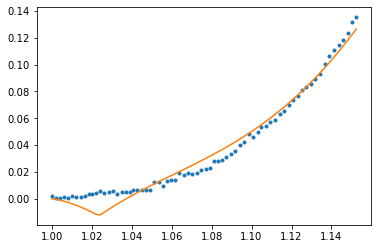

In [7]:
sigma_pr = NODE_lm2sigma_vmap(lamb, params, norm)
fig, ax = plt.subplots()
ax.plot(lamb[:,1], sigma_gt[:,0], '.')
ax.plot(lamb[:,1], sigma_pr[:,0], '-')

In [8]:
inp = np.linspace(0,3)
out = node_traj(params[0],inp)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.